<a href="https://colab.research.google.com/github/sayan0506/CNN-based-Classification-problem-using-Keras/blob/master/Image_Classification_with_CNNs_using_Keras_on_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with CNNs using Keras

# Task 1: Import Libraries

In [30]:
import tensorflow as tf
import os
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from keras.optimizers import Adam

%matplotlib inline

if not os.path.isdir('model'):
  os.mkdir('model')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.3.0
Is using GPU? True


# Task 2: Data loading and pre-processing

Here we are working on **CIFAR10 dataset**
This is a dataset of 50,000 32x32 color training images and 10,000 test images, which corresponds to 10 classes, but here the model is being trained for 3 classifying 3 main objects, which are ['Aeroplane, 'Car', 'Bird'].



* **Data Pre-processing**

  The **get_three_classes** function is used here to extract the images and   labels corresponding to the three classes which we want to classify.

In [31]:
def get_three_classes(x, y):
  def indices_of(class_id):
    indices, _ = np.where(y == float(class_id))
    return indices
  
  # indices of the images cprresponding to 3 classes
  indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)])
  
  x = x[indices]
  y = y[indices]

  count = x.shape[0]
  
  # shuffling
  indices = np.random.choice(range(count), size = count, replace=False)
  x = x[indices]
  y = y[indices]
  
  # helps to do the one hot encoding for the categorical labels
  y = tf.keras.utils.to_categorical(y)
  return x,y


CIFAR10 is a standard dataset of keras, which is being loaded here and preprocessed by the user-defined function. 

In [32]:
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()

print('Size of raw trained data: {0}, {1}'.format(x_train.shape, y_train.shape))
print('SIze of raw test data: {0}, {1}'.format(x_test.shape, y_test.shape))

x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print('Size of preprocessed trained data: {0}, {1}'.format(x_train.shape, y_train.shape))
print('SIze of preprocessed test data: {0}, {1}'.format(x_test.shape, y_test.shape))


Size of raw trained data: (50000, 32, 32, 3), (50000, 1)
SIze of raw test data: (10000, 32, 32, 3), (10000, 1)
Size of preprocessed trained data: (15000, 32, 32, 3), (15000, 3)
SIze of preprocessed test data: (3000, 32, 32, 3), (3000, 3)


# Task 3: Visualize Examples

Random training examples:


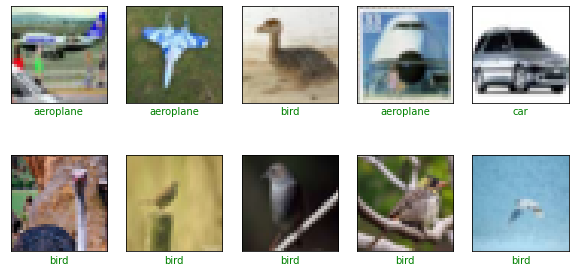

In [33]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    # getting random indices
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

print('Random training examples:')
show_random_examples(x_train, y_train, y_train)

Random test examples:


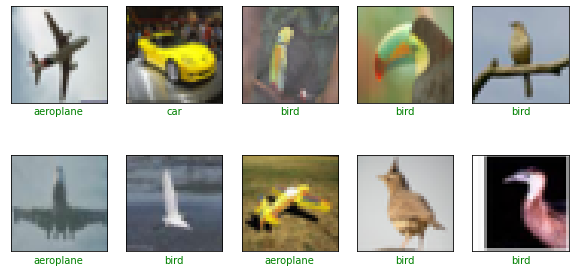

In [34]:
print('Random test examples:')
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

A CNN model is being created for the classifictaion of 3 classes from input images. 

Each of CNN block used in the architecture consists of

Conv2D layer(Relu activation) + BatchNorm + Conv2D layer(Relu activation) + Conv2D layer(Relu activation) + Maxpool layer + Deropout(0.2)

Note: Corresponding to each convolution block number of filters are cobstant across the block

After the model is built, it is being compiled, where
Optimizer = Adam

In [35]:

def create_model():
    # creates a convolution block
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    # model compilation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
print('Model_summary')
model.summary()

Model_summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 

# Task 5: Train the Model

Model is being trained for 20 epochs and trained parameters of the best model are saved in the 'model_{val_accuracy:.3f}.h5' file using the model checkpont callback, earlystoping is also used here with a patience = 2  

In [37]:
%%time

h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255.,y_test),
    epochs=20, batch_size=256,
    callbacks=[
        #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint('model/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Epoch 1/20
59/59 [==============================] - 3s 48ms/step - loss: 0.2357 - accuracy: 0.9074 - val_loss: 2.1033 - val_accuracy: 0.5057
Epoch 2/20
59/59 [==============================] - 3s 45ms/step - loss: 0.2158 - accuracy: 0.9177 - val_loss: 1.6115 - val_accuracy: 0.5900
Epoch 3/20
59/59 [==============================] - 3s 45ms/step - loss: 0.2010 - accuracy: 0.9220 - val_loss: 0.8845 - val_accuracy: 0.7073
Epoch 4/20
59/59 [==============================] - 3s 45ms/step - loss: 0.1797 - accuracy: 0.9305 - val_loss: 0.6584 - val_accuracy: 0.7883
Epoch 5/20
59/59 [==============================] - 3s 45ms/step - loss: 0.1583 - accuracy: 0.9383 - val_loss: 0.3002 - val_accuracy: 0.8897
Epoch 6/20
59/59 [==============================] - 3s 44ms/step - loss: 0.1496 - accuracy: 0.9431 - val_loss: 0.4468 - val_accuracy: 0.8553
Epoch 7/20
59/59 [==============================] - 3s 45ms/step - loss: 0.1295 - accuracy: 0.9507 - val_loss: 0.2876 - val_accuracy: 0.9030
Epoch 8/20
59

# Task 6: Final Predictions

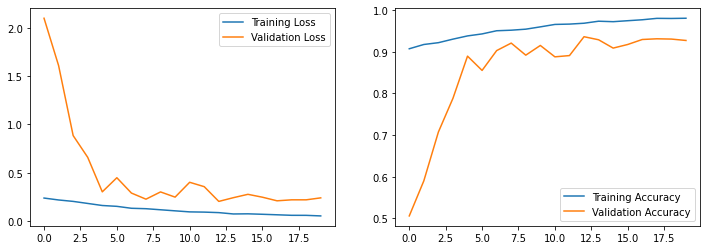

In [38]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

Predicting test_classes


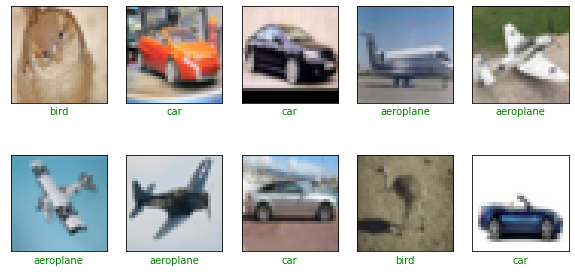

In [39]:
print('Predicting test_classes')
model = tf.keras.models.load_model('/content/model/model_0.933.h5')
preds = model.predict(x_test/255.)
show_random_examples(x_test, y_test, preds)

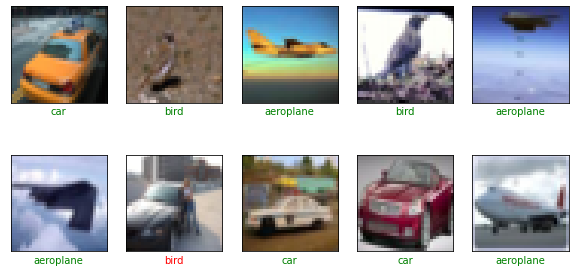